In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pydub import AudioSegment, silence
from pydub.utils import mediainfo_json
import nltk
from typing import List
import speechmetrics
from tqdm import tqdm
from mdutils.mdutils import MdUtils
import math
from wordfreq import word_frequency
from PIL import Image, ImageOps
from wordcloud import WordCloud, STOPWORDS
from g2p_en import G2p

from uberduck_ml_dev.text.util import clean_text, text_to_sequence

In [ ]:
def get_word_frequencies(word_list: List[str]) -> List[float]:
    freqs = []
    for word in word_list:
        freqs.append(word_frequency(word, "en"))
    return freqs

In [ ]:
def create_wordcloud(text: str, output_file: str):
    mask = np.array(ImageOps.invert(Image.open("duck.png").convert("RGB")))
    wc = WordCloud(
        background_color="white",
        max_words=3000,
        mask=mask,
        stopwords=set(STOPWORDS),
        contour_width=7,
        contour_color="steelblue",
    )
    wc.generate(text)
    wc.to_file(output_file)

In [ ]:
def calculate_statistics(
    dataset_path, input_file, img_folder, delimiter, metrics=True, wordcloud=True
):
    n_clips = 0
    sample_rates = {}
    channels = {"mono": 0, "stereo": 0}
    extensions = {}
    sample_formats = {}
    total_lengths = []
    leading_silence_lengths = []
    trailing_silence_lengths = []
    paces_characters = []  # number of characters / seconds in audio clip
    paces_phonemes = []  # number of phonemes / seconds in audio clip
    lookup_results = {}  # keep track of how arpabet sequences were generated
    mosnet_scores = []
    srmr_scores = []
    word_frequencies = []
    all_words = []
    g2p = G2p()

    if metrics:
        window_length = None  # seconds
        metrics = speechmetrics.load("absolute", None)

    with open(os.path.join(dataset_path, input_file)) as transcripts:
        for line in tqdm(transcripts):
            line = line.strip()  # remove trailing newline character
            file, transcription = line.lower().split(delimiter)
            transcription_cleaned = clean_text(transcription, ["english_cleaners"])

            filename, file_extension = os.path.splitext(file)

            file_pydub = AudioSegment.from_wav(os.path.join(dataset_path, file))

            # Format Metadata
            sr = file_pydub.frame_rate
            if sr in sample_rates.keys():
                sample_rates[sr] += 1
            else:
                sample_rates[sr] = 1

            if file_pydub.channels == 1:
                channels["mono"] += 1
            else:
                channels["stereo"] += 1

            if file_extension in extensions.keys():
                extensions[file_extension] += 1
            else:
                extensions[file_extension] = 1

            #  https://stackoverflow.com/questions/62677912/how-to-detect-a-floating-point-audio-file
            #  https://forum.videohelp.com/threads/373264-FFMpeg-List-of-working-sample-formats-per-format-and-encoder
            info = mediainfo_json(os.path.join(dataset_path, file))
            audio_streams = [x for x in info["streams"] if x["codec_type"] == "audio"]
            fmt = audio_streams[0].get("sample_fmt")
            if fmt in sample_formats.keys():
                sample_formats[fmt] += 1
            else:
                sample_formats[fmt] = 1

            # lengths
            total_lengths.append(file_pydub.duration_seconds)
            leading_silence_lengths.append(silence.detect_leading_silence(file_pydub))
            trailing_silence_lengths.append(
                silence.detect_leading_silence(file_pydub.reverse())
            )

            # Paces
            arpabet_seq = text_to_sequence(
                transcription_cleaned, ["english_cleaners"], p_arpabet=1.0
            )
            #             print("should be 1D array of arpabet tokens")
            #             print(arpabet_seq)
            paces_phonemes.append(len(arpabet_seq) / file_pydub.duration_seconds)
            paces_characters.append(
                len(transcription_cleaned) / file_pydub.duration_seconds
            )

            # Quality
            if metrics:
                scores = metrics(os.path.join(dataset_path, file))
                mosnet_scores.append(scores["mosnet"][0][0])
                srmr_scores.append(scores["srmr"])

            # Transcription
            word_frequencies.extend(get_word_frequencies(transcription_cleaned.split()))
            transcription_lookups = g2p.check_lookup(transcription_cleaned)
            for k in transcription_lookups:
                if k in lookup_results.keys():
                    lookup_results[k].extend(transcription_lookups[k])
                else:
                    lookup_results[k] = transcription_lookups[k]

            all_words.append(transcription_cleaned)

            n_clips += 1

    if wordcloud:
        create_wordcloud(
            " ".join(all_words), os.path.join(dataset_path, img_folder, "wordcloud.png")
        )

    # Length graph
    sns.histplot(total_lengths)
    plt.title("Audio length distribution")
    plt.xlabel("Audio length (s)")
    plt.ylabel("Count")
    plt.savefig(os.path.join(dataset_path, img_folder, "lengths.png"))

    # Word Frequencies graph
    plt.clf()
    sns.histplot(word_frequencies, bins=10)
    plt.title("Word frequency distribution [0-1]")
    plt.xlabel("Word frequency")
    plt.ylabel("Count")
    plt.xlim([0, 1])
    plt.savefig(os.path.join(dataset_path, img_folder, "word_frequencies.png"))

    # Silences graph
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(leading_silence_lengths)
    plt.title("Leading silence distribution")
    plt.xlabel("Leading silence (ms)")
    plt.ylabel("Count")
    plt.subplot(1, 2, 2)
    sns.histplot(trailing_silence_lengths)
    plt.title("Traling silence distribution")
    plt.xlabel("Trailing silence (ms)")
    plt.ylabel("Count")
    plt.savefig(os.path.join(dataset_path, img_folder, "silences.png"))

    # Metrics graph
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(mosnet_scores)
    plt.title("Mosnet score distribution")
    plt.xlabel("Mosnet score")
    plt.ylabel("Count")
    plt.subplot(1, 2, 2)
    sns.histplot(srmr_scores)
    plt.title("SRMR score distribution")
    plt.xlabel("SRMR score")
    plt.ylabel("Count")
    plt.savefig(os.path.join(dataset_path, img_folder, "metrics.png"))

    # Paces graph
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(paces_characters)
    plt.title("Pace (chars/s)")
    plt.xlabel("Characters / second")
    plt.ylabel("Count")
    plt.subplot(1, 2, 2)
    sns.histplot(paces_phonemes)
    plt.title("Pace (phonemes/s)")
    plt.xlabel("Phonemes / second")
    plt.ylabel("Count")
    plt.savefig(os.path.join(dataset_path, img_folder, "paces.png"))

    return {
        "n_clips": n_clips,
        "total_lengths": total_lengths,
        "paces_phonemes": paces_phonemes,
        "paces_characters": paces_characters,
        "mosnet_scores": mosnet_scores,
        "srmr_scores": srmr_scores,
        "sample_rates": sample_rates,
        "channels": channels,
        "extensions": extensions,
        "sample_formats": sample_formats,
        "lookup_results": lookup_results,
    }

In [ ]:
def generate_markdown(output_file, dataset_path, img_folder, data):
    mdFile = MdUtils(
        file_name=os.path.join(dataset_path, output_file), title=f"Dataset statistics"
    )

    total_length_mins = sum(data["total_lengths"]) / 60.0
    mdFile.new_header(level=1, title="Overview")
    mdFile.new_line(f"**Number of clips:** {data['n_clips']}")
    mdFile.new_line(
        f"**Total data:** {math.floor(total_length_mins)} minutes {math.ceil(total_length_mins % 1 * 60.0)} seconds"
    )
    mdFile.new_line(
        f"**Mean clip length:** {sum(data['total_lengths'])/data['n_clips']:.2f} seconds"
    )
    mdFile.new_line(
        f"**Mean pace:** {sum(data['paces_phonemes'])/len(data['paces_phonemes']):.2f} \
            phonemes/sec {sum(data['paces_characters'])/len(data['paces_characters']):.2f} chars/sec"
    )
    if len(data["mosnet_scores"]) > 0:
        mdFile.new_line(
            f"**Mean MOSNet:** {sum(data['mosnet_scores'])/len(data['mosnet_scores']):.2f}"
        )
        mdFile.new_line(
            f"**Mean SRMR:** {sum(data['srmr_scores'])/len(data['srmr_scores']):.2f}"
        )

    list_of_strings = ["Sample Rate (Hz)", "Count"]
    for k in data["sample_rates"].keys():
        list_of_strings.extend([str(k), str(data["sample_rates"][k])])
    mdFile.new_table(
        columns=2,
        rows=len(data["sample_rates"].keys()) + 1,
        text=list_of_strings,
        text_align="center",
    )

    list_of_strings = ["Audio Type", "Count"]
    n_rows = 1
    for k in data["channels"].keys():
        if data["channels"][k] > 0:
            n_rows += 1
            list_of_strings.extend([str(k), str(data["channels"][k])])
    mdFile.new_table(columns=2, rows=n_rows, text=list_of_strings, text_align="center")

    list_of_strings = ["Audio Format", "Count"]
    for k in data["extensions"].keys():
        list_of_strings.extend([str(k), str(data["extensions"][k])])
    mdFile.new_table(
        columns=2,
        rows=len(data["extensions"].keys()) + 1,
        text=list_of_strings,
        text_align="center",
    )

    list_of_strings = ["Sample Format", "Count"]
    for k in data["sample_formats"].keys():
        list_of_strings.extend([str(k), str(data["sample_formats"][k])])
    mdFile.new_table(
        columns=2,
        rows=len(data["sample_formats"].keys()) + 1,
        text=list_of_strings,
        text_align="center",
    )

    list_of_strings = ["Arpabet Lookup Type", "Count"]
    for k in data["lookup_results"].keys():
        list_of_strings.extend([str(k), str(len(data["lookup_results"][k]))])
    mdFile.new_table(
        columns=2,
        rows=len(data["lookup_results"].keys()) + 1,
        text=list_of_strings,
        text_align="center",
    )
    mdFile.new_line(
        mdFile.new_inline_image(
            text="Wordcloud", path=os.path.join(img_folder, "wordcloud.png")
        )
    )
    mdFile.new_line(
        mdFile.new_inline_image(
            text="Audio Lengths", path=os.path.join(img_folder, "lengths.png")
        )
    )
    mdFile.new_line(
        mdFile.new_inline_image(
            text="Paces", path=os.path.join(img_folder, "paces.png")
        )
    )
    mdFile.new_line(
        mdFile.new_inline_image(
            text="Silences", path=os.path.join(img_folder, "silences.png")
        )
    )
    if len(data["mosnet_scores"]) > 0:
        mdFile.new_line(
            mdFile.new_inline_image(
                text="Metrics", path=os.path.join(img_folder, "metrics.png")
            )
        )
    mdFile.new_line(
        mdFile.new_inline_image(
            text="Word Frequencies",
            path=os.path.join(img_folder, "word_frequencies.png"),
        )
    )

    mdFile.new_line(
        f'**Arpabet sequences obtained via g2P RNN:** {" ".join(data["lookup_results"]["RNN"])}'
    )

    mdFile.create_md_file()

In [ ]:
def parse_args(args):
    parser = argparse.ArgumentParser()
    parser.add_argument("-d", "--dataset_path", help="Path to the dataset.", type="str")
    parser.add_argument(
        "-i", "--input_file", help="Path to the transcription file.", type="str"
    )
    parser.add_argument(
        "-o",
        "--output_file",
        help="Markdown file to write statistics to.",
        type="str",
        default="STATISTICS",
    )
    parser.add_argument(
        "-m",
        "--metrics",
        help="Boolean value to calculate SRMR and MOSNet.",
        default=True,
        type=bool,
    )
    parser.add_argument(
        "--img_folder",
        help="Folder to save plots and images.",
        type="str",
        default="stats",
    )
    parser.add_argument(
        "--delimiter", help="Transcription file delimiter.", type="str", default="|"
    )

    return parser.parse_args(args)

In [ ]:
def run(
    dataset_path, input_file, output_file, img_folder, delimiter, metrics, wordcloud
):
    os.makedirs(os.path.join(dataset_path, img_folder), exist_ok=True)
    data = calculate_statistics(
        dataset_path, input_file, img_folder, delimiter, metrics, wordcloud
    )
    generate_markdown(output_file, dataset_path, img_folder, data)

573it [00:38, 14.98it/s]


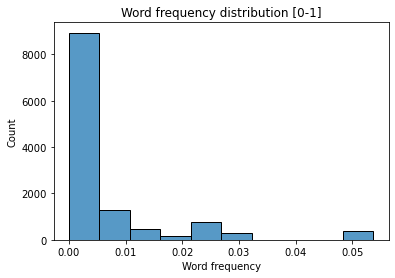

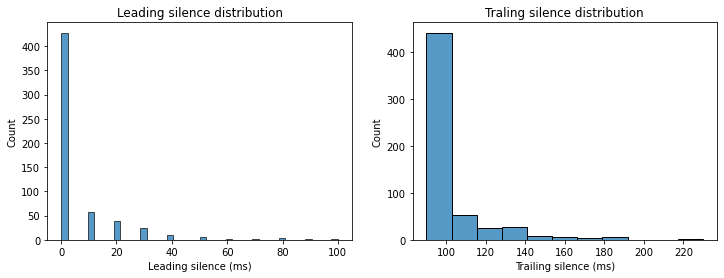

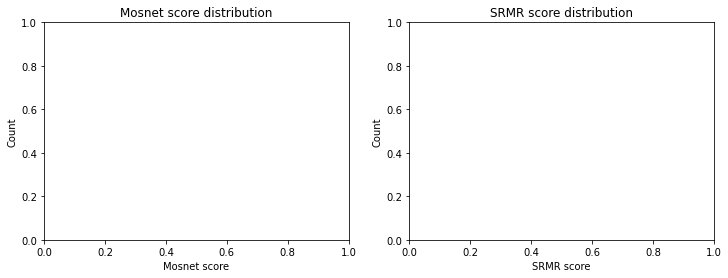

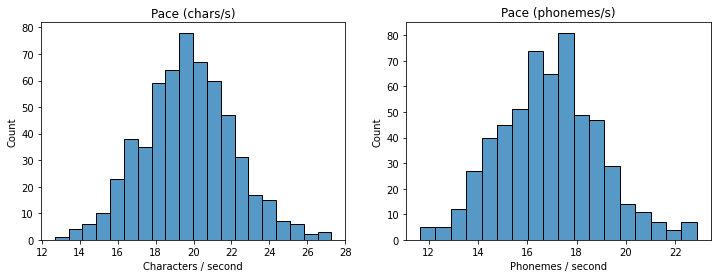

In [ ]:
run(
    dataset_path="/home/ubuntu/dataset_description/data/eminem",
    input_file="all.txt",
    output_file="STATISTICS.md",
    img_folder="imgs",
    delimiter="|",
    metrics=False,
    wordcloud=True,
)

In [ ]:
# # export

# try:
#     from nbdev.imports import IN_NOTEBOOK
# except:
#     IN_NOTEBOOK = False

# if __name__ == "__main__" and not IN_NOTEBOOK:
#     args = parse_args(sys.argv[1:])
#     run(
#         args.dataset_path,
#         args.input_file,
#         args.output_file,
#         args.metrics,
#         args.img_folder,
#         args.delimiter,
#     )